# **SEGMENTING AND CLUSTERING NEIGHBORHOODS WITH LEVEL OF RISK FROM COVID-19** 
---

# 0. Importing Libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#!conda install -c districtdatalabs yellowbrick
from yellowbrick.cluster import KElbowVisualizer

import types
from botocore.client import Config
import ibm_boto3
from project_lib import Project

# 1. Getting Delhi's postal code, district and neighborhood

## 1.1. Loading data

In [86]:
# The code was removed by Watson Studio for sharing.

(538, 3)


,Postal Code,Borough,Neighborhood
0,110001,Central Delhi,Connaught Place
1,110001,Central Delhi,North Avenue
2,110001,New Delhi,New Delhi G.P.O.
3,110001,Central Delhi,Parliament House
4,110001,Central Delhi,Patiala House


##  1.2 Grouping the data by postal code


In [87]:
df= (df_raw.groupby('Postal Code').agg({'Borough': lambda x: x.value_counts().index[0],'Neighborhood': lambda x:', '.join(x)}).reset_index())
df= df.rename(columns={'Postal Code': 'Postal_Code'})

print(df.shape)
df

(95, 3)


,Postal_Code,Borough,Neighborhood
0,110001,Central Delhi,"Connaught Place, North Avenue, New Delhi G.P.O..."
1,110002,Central Delhi,"Indraprastha, A.G.C.R., Darya Ganj, Minto Road..."
2,110003,South Delhi,"C G O Complex, Kasturba Nagar (South Delhi), D..."
3,110004,Central Delhi,Rashtrapati Bhawan
4,110005,Central Delhi,"Bank Street (Central Delhi), Guru Gobind Singh..."
5,110006,North Delhi,"Delhi G.P.O., Jama Masjid, Chawri Bazar, Chand..."
6,110007,North Delhi,"C.C.I., Jawahar Nagar (North Delhi), Kamla Nag..."
7,110008,Central Delhi,"Dada Ghosh Bhawan, Patel Nagar West, Patel Nag..."
8,110009,North West Delhi,"Model Town II, Model Town III, Gujranwala Colo..."
9,110010,South West Delhi,"505 A B Workshop, COD (South West Delhi), Dhau..."


# 2. Geo-coordinates for plotting on map

## 2.1. Getting Delhi's geo-coordinates

In [88]:
address = 'Delhi India'

geolocator = Nominatim(user_agent="delhi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Delhi are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Delhi are 28.6517178, 77.2219388.


## 2.2. Getting geo-coordinates of postal codes in Delhi

In [89]:
x=[]
y=[]
df_temp = df.iloc[:,0]

geolocator = Nominatim(user_agent="delhi_explorer")

for i in range (0, len(df_temp)):
    loc = geolocator.geocode(str(df_temp[i])+', Delhi, India')
    if (loc != None):
        x.append(loc.latitude)
        y.append(loc.longitude)
    else:
        x.append('NaN')
        y.append('NaN')


## 2.3. Merging geo-coordinated to our data 

In [90]:
df['Latitude']=x
df['Longitude']=y

df= df[df['Latitude']!='NaN']
df.astype({'Latitude': 'float64','Longitude':'float64'}).dtypes

print (df.shape)
df.head()

(93, 5)


,Postal_Code,Borough,Neighborhood,Latitude,Longitude
0,110001,Central Delhi,"Connaught Place, North Avenue, New Delhi G.P.O...",28.6517,77.2219
1,110002,Central Delhi,"Indraprastha, A.G.C.R., Darya Ganj, Minto Road...",28.641,77.2455
2,110003,South Delhi,"C G O Complex, Kasturba Nagar (South Delhi), D...",28.5987,77.223
3,110004,Central Delhi,Rashtrapati Bhawan,28.6161,77.2045
4,110005,Central Delhi,"Bank Street (Central Delhi), Guru Gobind Singh...",28.6505,77.1883


# 3. Delhi's population density and contaminated zones

## 3.1 Loading

In [91]:
data = {'Borough':['North West Delhi', 'South Delhi', 'West Delhi', 'South West Delhi', 'North East Delhi', 'East Delhi', 'North Delhi', 'Central Delhi', 'New Delhi'], 
        'Population_Density':[8254,11060,19563,5446,36155,27132,14557,27730,4057],
        'Contaminated_Zone':[11,33,6,5,11,7,6,3,2]}

df_pop = pd.DataFrame(data) 

df_pop

,Borough,Population_Density,Contaminated_Zone
0,North West Delhi,8254,11
1,South Delhi,11060,33
2,West Delhi,19563,6
3,South West Delhi,5446,5
4,North East Delhi,36155,11
5,East Delhi,27132,7
6,North Delhi,14557,6
7,Central Delhi,27730,3
8,New Delhi,4057,2


## 3.2 Merging to our main data frame

In [92]:
df = pd.merge(df, df_pop, how='left', on='Borough')

print (df.shape)
df.head()

(93, 7)


,Postal_Code,Borough,Neighborhood,Latitude,Longitude,Population_Density,Contaminated_Zone
0,110001,Central Delhi,"Connaught Place, North Avenue, New Delhi G.P.O...",28.6517,77.2219,27730,3
1,110002,Central Delhi,"Indraprastha, A.G.C.R., Darya Ganj, Minto Road...",28.641,77.2455,27730,3
2,110003,South Delhi,"C G O Complex, Kasturba Nagar (South Delhi), D...",28.5987,77.223,11060,33
3,110004,Central Delhi,Rashtrapati Bhawan,28.6161,77.2045,27730,3
4,110005,Central Delhi,"Bank Street (Central Delhi), Guru Gobind Singh...",28.6505,77.1883,27730,3


# 4. Plotting point on interest on map (postal code)

In [93]:
# create map of delhi using latitude and longitude values
map_delhi = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, postal_code, neighborhood in zip(df['Latitude'], df['Longitude'], df['Postal_Code'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, postal_code)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_delhi)  
    

print('WE WILL BE USING ANALYSING AND CLUSTERING THE AREAS MARKED BELOW ON THE MAP IN FURTHER SECTIONS.')
    
map_delhi

WE WILL BE USING ANALYSING AND CLUSTERING THE AREAS MARKED BELOW ON THE MAP IN FURTHER SECTIONS.


# 5. Foursqare API

## 5.1 Foursquare API credentials

In [53]:
# The code was removed by Watson Studio for sharing.

## 5.2. Exploring pont of interest/neighbourhood on map

### 5.2.1 Creating function (to be used to explore each Neighbourhood in Delhi)

In [94]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # radiun   

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### 5.2.2. Getting/Exploring Venues (for each neighbhourhood using the function in *5.2.1*)

In [95]:
delhi_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Connaught Place, North Avenue, New Delhi G.P.O., Parliament House, Patiala House, Sansadiya Soudh, Krishi Bhawan, Lady Harding Medical College, Janpath, Rail Bhawan, Pragati Maidan, Supreme Court, Sansad Marg, Pragati Maidan Camp, Shastri Bhawan, Baroda House, Secretariat North, Election Commission, Bhagat Singh Market, Bengali Market, Constitution House
Indraprastha, A.G.C.R., Darya Ganj, Minto Road, I.P.Estate, Gandhi Smarak Nidhi, Ajmeri Gate Extn.
C G O Complex, Kasturba Nagar (South Delhi), Delhi High Court Extension Counter, Aliganj (South Delhi), Pandara Road, Lodi Road, Delhi High Court, Pragati Vihar, Golf Links, Safdarjung Air Port
Rashtrapati Bhawan
Bank Street (Central Delhi), Guru Gobind Singh Marg, Anand Parbat, Anand Parbat Indl. Area, Master Prithvi Nath Marg, Karol Bagh, Sat Nagar, Desh Bandhu Gupta Road
Delhi G.P.O., Jama Masjid, Chawri Bazar, Chandni Chowk, Baratooti, Delhi Sadar Bazar, Hauz Qazi, Dareeba, S.T. Road
C.C.I., Jawahar Nagar (North Delhi), Kamla Nagar (N

### 5.2.3 Printing venues returned from function *5.2.1* 

In [96]:
print(delhi_venues.shape)
delhi_venues.head()

(1514, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Connaught Place, North Avenue, New Delhi G.P.O...",28.651718,77.221939,Amritsari Lassi Wala,28.657325,77.224138,Snack Place
1,"Connaught Place, North Avenue, New Delhi G.P.O...",28.651718,77.221939,Kake Di Hatti | काके दी हट्टी,28.658050,77.223377,Indian Restaurant
2,"Connaught Place, North Avenue, New Delhi G.P.O...",28.651718,77.221939,bloomrooms @ New Delhi Railway Station,28.645537,77.217701,Hotel
3,"Connaught Place, North Avenue, New Delhi G.P.O...",28.651718,77.221939,Spice Market,28.657287,77.222595,Food & Drink Shop
4,"Connaught Place, North Avenue, New Delhi G.P.O...",28.651718,77.221939,Giani's Di Hatti Rabri Faluda,28.657889,77.223296,Dessert Shop


### 5.2.4 Saving venues returned to CSV file  

In [16]:
# The code was removed by Watson Studio for sharing.

{'file_name': 'foursquare_final.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'applieddatasciencecapstone-donotdelete-pr-tkppm8dgdyw7af',
 'asset_id': '2b108814-cc52-4b6b-a281-3b3b53ed12fd'}

# 6. Exploratory analysis

## 6.1 Types of venue category returned

In [97]:
print('There are {} uniques categories.'.format(len(delhi_venues['Venue Category'].unique())))

There are 160 uniques categories.


## 6.2. Counting top 10 venue retrived in Delhi

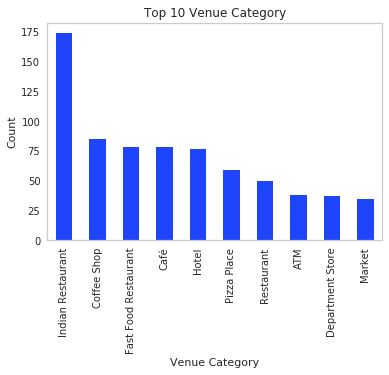

In [98]:
delhi_venues['Venue Category'].value_counts().head(10).plot(kind='bar',color="#1F45FC")
plt.title('Top 10 Venue Category')
plt.xlabel('Venue Category')
plt.ylabel('Count')
plt.grid(False)

## 6.3. Counting number of venues returned for each neighborhood in Delhi

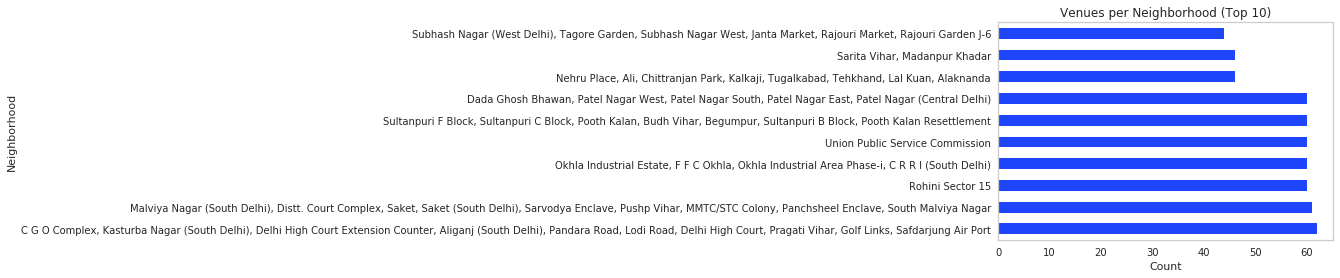

In [99]:
delhi_venues.groupby('Neighborhood').Venue.count().sort_values(ascending=False).head(10).plot(kind='barh',color="#1F45FC")
plt.title('Venues per Neighborhood (Top 10)')
plt.xlabel('Count')
plt.ylabel('Neighborhood')
plt.grid(False)


## 6.4 Adding number of venues around each neighborhood to main data frame

In [100]:
Venue_Count=pd.DataFrame(delhi_venues.groupby('Neighborhood').Venue.count().reset_index())
Venue_Count.rename(columns={'Venue': 'Venue_Count'}, inplace=True)

df = pd.merge(df, Venue_Count, how='left', on='Neighborhood')
print (df.shape)
df.head()

(93, 8)


,Postal_Code,Borough,Neighborhood,Latitude,Longitude,Population_Density,Contaminated_Zone,Venue_Count
0,110001,Central Delhi,"Connaught Place, North Avenue, New Delhi G.P.O...",28.6517,77.2219,27730,3,31.0
1,110002,Central Delhi,"Indraprastha, A.G.C.R., Darya Ganj, Minto Road...",28.641,77.2455,27730,3,18.0
2,110003,South Delhi,"C G O Complex, Kasturba Nagar (South Delhi), D...",28.5987,77.223,11060,33,62.0
3,110004,Central Delhi,Rashtrapati Bhawan,28.6161,77.2045,27730,3,9.0
4,110005,Central Delhi,"Bank Street (Central Delhi), Guru Gobind Singh...",28.6505,77.1883,27730,3,31.0


## 6.5. Analyzing Each Neighborhood


### 6.5.1 One hot encoding venues in each neighborhood

In [101]:
# one hot encoding
delhi_onehot = pd.get_dummies(delhi_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
delhi_onehot['Neighborhood'] = delhi_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [delhi_onehot.columns[-1]] + list(delhi_onehot.columns[:-1])
delhi_onehot = delhi_onehot[fixed_columns]

print(delhi_onehot.shape)
delhi_onehot.head()

(1514, 160)


,Women's Store,ATM,Accessories Store,Airport,Airport Food Court,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Bengali Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Coworking Space,Cricket Ground,Department Store,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farm,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Hindu Temple,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Irani Cafe,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mosque,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multicuisine Indian Restaurant,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Nightlife Spot,North Indian Restaurant,Northeast Indian Restaurant,Other Great Outdoors,Paper / Office Supplies Store,Park,Parking,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Resort,Restaurant,Road,Salad Place,Sandwich Place,Scenic Lookout,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Stadium,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Warehouse Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Connaught Place, North Avenue, New Delhi G.P.O...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Connaught Place, North Avenue, New Delhi G.P.O...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Connaught Place, North Avenue, New Delhi G.P.O...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Connaught Place, North Avenue, New Delhi G.P.O...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Connaught Place, North Avenue, New Delhi G.P.O...",0,0,

### 6.5.2. Grouping neighborhood

In [102]:
delhi_grouped = delhi_onehot.groupby('Neighborhood').mean().reset_index()

print(delhi_grouped.shape)
delhi_grouped.head()

(90, 160)


,Neighborhood,Women's Store,ATM,Accessories Store,Airport,Airport Food Court,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Bengali Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Coworking Space,Cricket Ground,Department Store,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farm,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Hindu Temple,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Irani Cafe,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mosque,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multicuisine Indian Restaurant,Multiplex,Museum,Music Venue,Nightclub,Nightlife Spot,North Indian Restaurant,Northeast Indian Restaurant,Other Great Outdoors,Paper / Office Supplies Store,Park,Parking,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Resort,Restaurant,Road,Salad Place,Sandwich Place,Scenic Lookout,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Stadium,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Warehouse Store
0,"505 A B Workshop, COD (South West Delhi), Dhau...",0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064516,0.0,0.00000,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,0.032258,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,0.032258,0.0,0.0,0.032258,0.129032,0.0,0.0,0.00000,0.193548,0.0,0.000000,0.0,0.032258,0.0,0.0,0.0,0.00000,0.0,0.0,0.064516,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064516,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.129032,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"A F Rajokari, Rajokari",0.0,1.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Air Force Station Tugalkabad, Deoli, Dakshinpu...",0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000

### 6.5.3. Top 5 venues in each neighbourhood with their frequency

In [20]:
num_top_venues = 5

for hood in delhi_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = delhi_grouped[delhi_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----505 A B Workshop, COD (South West Delhi), Dhaula Kuan, Bazar Road, Aps Colony, A F Palam, Signal Enclave, Delhi Cantt, C.V.D., R R Hospital, Kirby Place, Pinto Park, Station Road (South West Delhi), Subroto Park----
               venue  freq
0  Indian Restaurant  0.19
1              Hotel  0.13
2        Snack Place  0.13
3             Market  0.06
4       Dessert Shop  0.06


----A F Rajokari, Rajokari----
             venue  freq
0              ATM   1.0
1        Hotel Bar   0.0
2           Mosque   0.0
3            Motel   0.0
4  Motorcycle Shop   0.0


----Air Force Station Tugalkabad, Deoli, Dakshinpuri Phase-II, BSF Camp Tigri, Dakshinpuri Phase-III, Dr. Ambedkar Nagar (South Delhi), Dakshinpuri Phase-I, Hamdard Nagar, Pushpa Bhawan, Khanpur (South Delhi), Talimabad----
             venue  freq
0   Sandwich Place   1.0
1    Women's Store   0.0
2      Pizza Place   0.0
3            Motel   0.0
4  Motorcycle Shop   0.0


----Alipur, Kadipur, Bakhtawar Pur, Palla, Bakoli, Mukhme

### 6.5.4.  Returning top 10 venues in each neighbourhood

#### Function defination for top 10

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Calling function to get top 10 

In [103]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = delhi_grouped['Neighborhood']

for ind in np.arange(delhi_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"505 A B Workshop, COD (South West Delhi), Dhau...",Indian Restaurant,Hotel,Snack Place,Market,Dessert Shop,Restaurant,Historic Site,Hardware Store,Hostel,Jewelry Store
1,"A F Rajokari, Rajokari",ATM,Warehouse Store,Dumpling Restaurant,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farm,Electronics Store,Eastern European Restaurant
2,"Air Force Station Tugalkabad, Deoli, Dakshinpu...",Sandwich Place,Warehouse Store,College Cafeteria,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farm,Electronics Store,Eastern European Restaurant
3,"Alipur, Kadipur, Bakhtawar Pur, Palla, Bakoli,...",Hotel,Bus Station,Farm,Resort,ATM,Coworking Space,Cosmetics Shop,Food,Flower Shop,Flea Market
4,"Amar Colony, Lajpat Nagar (South Delhi), Defen...",Indian Restaurant,Italian Restaurant,Café,Sandwich Place,French Restaurant,Market,Bakery,Coffee Shop,Hotel,Chinese Restaurant


# 7. K-Means Clustering

## 7.1. Pre-processing dataframe

In [104]:
scaled = StandardScaler().fit_transform(df.iloc[:,[5,6,7]].values)
scaled=pd.DataFrame(data=scaled)

df['Population_Density']=scaled[0]
df['Contaminated_Zone']=scaled[1]
df['Venue_Count']=scaled[2]

print(df.shape)
df.head()

(93, 8)


,Postal_Code,Borough,Neighborhood,Latitude,Longitude,Population_Density,Contaminated_Zone,Venue_Count
0,110001,Central Delhi,"Connaught Place, North Avenue, New Delhi G.P.O...",28.6517,77.2219,1.679327,-0.774665,0.832051
1,110002,Central Delhi,"Indraprastha, A.G.C.R., Darya Ganj, Minto Road...",28.641,77.2455,1.679327,-0.774665,0.069120
2,110003,South Delhi,"C G O Complex, Kasturba Nagar (South Delhi), D...",28.5987,77.223,-0.309525,2.214705,2.651348
3,110004,Central Delhi,Rashtrapati Bhawan,28.6161,77.2045,1.679327,-0.774665,-0.459063
4,110005,Central Delhi,"Bank Street (Central Delhi), Guru Gobind Singh...",28.6505,77.1883,1.679327,-0.774665,0.832051


## 7.2. Formatting data to be used as input for k-means clustering

In [105]:
delhi_grouped = pd.merge(delhi_grouped, df[['Neighborhood','Population_Density','Contaminated_Zone','Venue_Count']], how='left', on='Neighborhood')
delhi_grouped_clustering = delhi_grouped.drop('Neighborhood', 1)

print(delhi_grouped_clustering.shape)
delhi_grouped_clustering.head()

(90, 162)


,Women's Store,ATM,Accessories Store,Airport,Airport Food Court,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Bengali Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Coworking Space,Cricket Ground,Department Store,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farm,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Hindu Temple,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Irani Cafe,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mosque,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multicuisine Indian Restaurant,Multiplex,Museum,Music Venue,Nightclub,Nightlife Spot,North Indian Restaurant,Northeast Indian Restaurant,Other Great Outdoors,Paper / Office Supplies Store,Park,Parking,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Resort,Restaurant,Road,Salad Place,Sandwich Place,Scenic Lookout,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Stadium,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Warehouse Store,Population_Density,Contaminated_Zone,Venue_Count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064516,0.0,0.00000,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,0.032258,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,0.032258,0.0,0.0,0.032258,0.129032,0.0,0.0,0.00000,0.193548,0.0,0.000000,0.0,0.032258,0.0,0.0,0.0,0.00000,0.0,0.0,0.064516,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064516,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.129032,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.979316,-0.575373,0.832051
1,0.0,1.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.979316,-0.575373,-0.928559
2,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0

## 7.3. Selecting the right 'K'

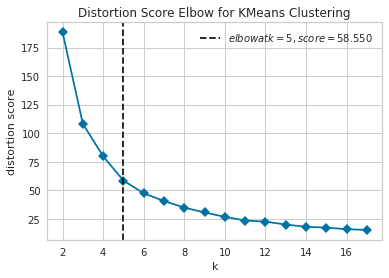

In [109]:
model = KMeans(init = "k-means++",random_state=1)
visualizer = KElbowVisualizer(model, k=(2,18), timings=False)

visualizer.fit(delhi_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()  

## 7.4. Defining k-means parameters and creating clusters of delhi neighborhood

In [110]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init = "k-means++", random_state=1).fit(delhi_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([1, 1, 3, 1, 2, 1, 1, 1, 0, 2, 0, 0, 0, 0, 1, 4, 3, 4, 4, 1, 1, 3,
       4, 1, 3, 0, 4, 1, 1, 3, 4, 1, 3, 4, 2, 4, 4, 1, 1, 1, 1, 1, 4, 4,
       1, 2, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 2, 4, 1, 0, 2, 4, 1, 1, 1,
       0, 4, 2, 1, 4, 1, 3, 2, 1, 4, 4, 1, 1, 4, 0, 3, 2, 1, 0, 4, 4, 1,
       1, 4], dtype=int32)

## 7.5. Adding cluster lables to dataframe 

In [111]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

delhi_merged = df

# merge delhi_grouped with delhi_data to add latitude/longitude for each neighborhood
delhi_merged = delhi_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

delhi_merged.head() # check the last columns!

,Postal_Code,Borough,Neighborhood,Latitude,Longitude,Population_Density,Contaminated_Zone,Venue_Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,110001,Central Delhi,"Connaught Place, North Avenue, New Delhi G.P.O...",28.6517,77.2219,1.679327,-0.774665,0.832051,0.0,Indian Restaurant,Hotel,Snack Place,Market,Dessert Shop,Restaurant,Historic Site,Hardware Store,Hostel,Jewelry Store
1,110002,Central Delhi,"Indraprastha, A.G.C.R., Darya Ganj, Minto Road...",28.641,77.2455,1.679327,-0.774665,0.069120,4.0,Indian Restaurant,Hotel,Hostel,Restaurant,Stadium,History Museum,Movie Theater,Cricket Ground,Road,Soccer Stadium
2,110003,South Delhi,"C G O Complex, Kasturba Nagar (South Delhi), D...",28.5987,77.223,-0.309525,2.214705,2.651348,2.0,Café,Chinese Restaurant,Coffee Shop,Hotel Bar,Asian Restaurant,Bar,Indian Restaurant,Park,Restaurant,Hotel
3,110004,Central Delhi,Rashtrapati Bhawan,28.6161,77.2045,1.679327,-0.774665,-0.459063,4.0,Food & Drink Shop,Museum,Smoke Shop,Spiritual Center,Garden,Metro Station,Asian Restaurant,Tea Room,Music Venue,Department Store
4,110005,Central Delhi,"Bank Street (Central Delhi), Guru Gobind Singh...",28.6505,77.1883,1.679327,-0.774665,0.832051,0.0,Hotel,Indian Restaurant,Coffee Shop,Fast Food Restaurant,Snack Place,Bakery,Food & Drink Shop,Pizza Place,Burrito Place,Restaurant


## 7.6.  Creating Delhi clustered neighborhood map

In [112]:
# dropping clusters with no data
delhi_merged=delhi_merged.dropna()


# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11,control_scale = True)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(delhi_merged['Latitude'], delhi_merged['Longitude'], delhi_merged['Neighborhood'], delhi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 8. Exploring Clusters

## 8.1. Cluster 1

In [113]:
Cluster_1 = delhi_merged.loc[delhi_merged['Cluster Labels'] == 0, delhi_merged.columns[[0] + list(range(5, 10))]]
Cluster_1

,Postal_Code,Population_Density,Contaminated_Zone,Venue_Count,Cluster Labels,1st Most Common Venue
0,110001,1.679327,-0.774665,0.832051,0.0,Indian Restaurant
4,110005,1.679327,-0.774665,0.832051,0.0,Hotel
5,110006,0.107692,-0.475728,0.890738,0.0,Indian Restaurant
6,110007,0.107692,-0.475728,0.655990,0.0,Breakfast Spot
7,110008,1.679327,-0.774665,2.533974,0.0,Indian Restaurant
10,110011,1.679327,-0.774665,0.832051,0.0,Indian Restaurant
11,110012,1.679327,-0.774665,0.832051,0.0,Indian Restaurant
26,110027,0.704944,-0.475728,1.594982,0.0,Fast Food Restaurant
58,110060,1.679327,-0.774665,0.890738,0.0,Hotel
67,110069,1.679327,-0.774665,2.533974,0.0,Indian Restaurant


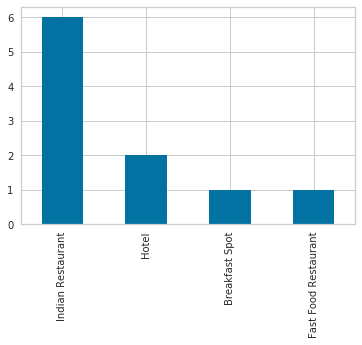

In [114]:
Cluster_1['1st Most Common Venue'].value_counts().plot(kind='bar')

## 8.2. Cluster 2


In [115]:
Cluster_2 = delhi_merged.loc[delhi_merged['Cluster Labels'] == 1, delhi_merged.columns[[0] + list(range(5, 10))]]
Cluster_2

,Postal_Code,Population_Density,Contaminated_Zone,Venue_Count,Cluster Labels,1st Most Common Venue
8,110009,-0.644302,0.022501,-0.576437,1.0,Coffee Shop
9,110010,-0.979316,-0.575373,0.832051,1.0,Indian Restaurant
15,110016,-0.979316,-0.575373,-0.400376,1.0,Indian Restaurant
20,110021,-0.979316,-0.575373,-0.048254,1.0,Coffee Shop
21,110022,-0.979316,-0.575373,-0.048254,1.0,Park
22,110023,-0.979316,-0.575373,0.010433,1.0,Fast Food Restaurant
27,110028,-0.979316,-0.575373,-0.635124,1.0,Café
28,110029,-0.979316,-0.575373,-0.341689,1.0,Indian Restaurant
29,110030,-0.979316,-0.575373,-0.283002,1.0,Coffee Shop
32,110033,-0.644302,0.022501,-0.693811,1.0,ATM


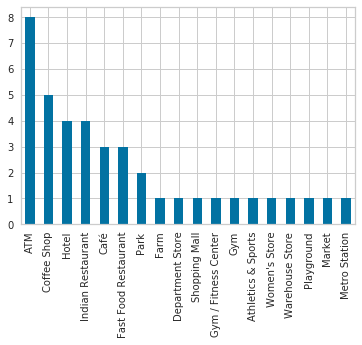

In [116]:
Cluster_2['1st Most Common Venue'].value_counts().plot(kind='bar')

## 8.3. Cluster 3


In [117]:
Cluster_3=delhi_merged.loc[delhi_merged['Cluster Labels'] == 2, delhi_merged.columns[[0] + list(range(5, 10))]]
Cluster_3

,Postal_Code,Population_Density,Contaminated_Zone,Venue_Count,Cluster Labels,1st Most Common Venue
2,110003,-0.309525,2.214705,2.651348,2.0,Café
16,110017,-0.309525,2.214705,2.592661,2.0,Coffee Shop
18,110019,-0.309525,2.214705,1.712356,2.0,Indian Restaurant
19,110020,-0.309525,2.214705,2.533974,2.0,Indian Restaurant
23,110024,-0.309525,2.214705,1.418921,2.0,Indian Restaurant
47,110048,-0.309525,2.214705,1.536295,2.0,Hotel
74,110076,-0.309525,2.214705,1.712356,2.0,Indian Restaurant
83,110086,-0.644302,0.022501,2.533974,2.0,Indian Restaurant
86,110089,-0.644302,0.022501,2.533974,2.0,Indian Restaurant


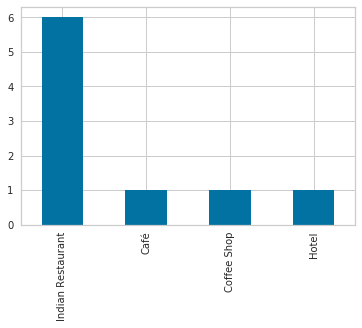

In [118]:
Cluster_3['1st Most Common Venue'].value_counts().plot(kind='bar')

## 8.4. Cluster 4


In [119]:
Cluster_4 = delhi_merged.loc[delhi_merged['Cluster Labels'] == 3, delhi_merged.columns[[0] + list(range(5, 12))]]
Cluster_4

,Postal_Code,Population_Density,Contaminated_Zone,Venue_Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
12,110013,-0.309525,2.214705,-0.576437,3.0,Food Court,Bus Station,Flea Market
13,110014,-0.309525,2.214705,-0.576437,3.0,Food Court,Bus Station,Flea Market
24,110025,-0.309525,2.214705,-0.224315,3.0,Café,Pizza Place,Indian Restaurant
43,110044,-0.309525,2.214705,-0.635124,3.0,Train Station,Indian Restaurant,Snack Place
48,110049,-0.309525,2.214705,0.479929,3.0,Coffee Shop,Park,Bar
60,110062,-0.309525,2.214705,-0.928559,3.0,Sandwich Place,Warehouse Store,College Cafeteria
63,110065,-0.309525,2.214705,-0.106941,3.0,Pizza Place,Restaurant,Indian Restaurant
77,110080,-0.309525,2.214705,-0.635124,3.0,ATM,Trail,Ice Cream Shop


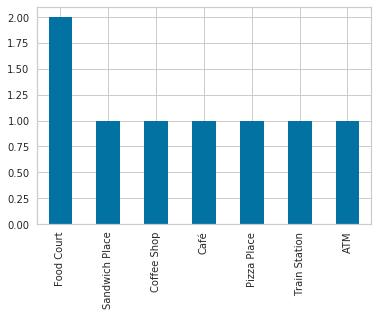

In [135]:
Cluster_4['1st Most Common Venue'].value_counts().plot(kind='bar')

## 8.5. Cluster 5


In [121]:
Cluster_5 = delhi_merged.loc[delhi_merged['Cluster Labels'] == 4, delhi_merged.columns[[0] + list(range(5, 10))]]
Cluster_5

,Postal_Code,Population_Density,Contaminated_Zone,Venue_Count,Cluster Labels,1st Most Common Venue
1,110002,1.679327,-0.774665,0.069120,4.0,Indian Restaurant
3,110004,1.679327,-0.774665,-0.459063,4.0,Food & Drink Shop
14,110015,0.704944,-0.475728,-0.752498,4.0,Hotel
17,110018,0.704944,-0.475728,-0.752498,4.0,Café
25,110026,0.704944,-0.475728,-0.106941,4.0,Metro Station
30,110031,1.607981,-0.376082,-0.576437,4.0,Indian Restaurant
31,110032,1.607981,-0.376082,-0.752498,4.0,Shopping Plaza
40,110041,0.704944,-0.475728,-0.811185,4.0,ATM
49,110051,1.607981,-0.376082,-0.752498,4.0,Pizza Place
51,110053,1.607981,-0.376082,-0.459063,4.0,ATM


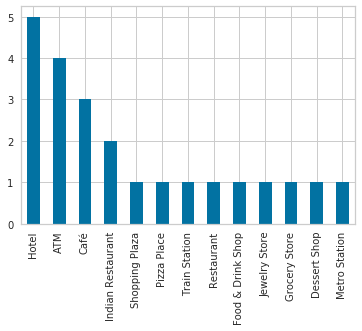

In [122]:
Cluster_5['1st Most Common Venue'].value_counts().plot(kind='bar')

In [166]:
delhi_merged.groupby('Cluster Labels').agg({'Population_Density': 'mean' , 
                                            'Contaminated_Zone': 'mean' , 
                                            'Venue_Count': 'mean' , 
                                            '1st Most Common Venue': lambda x:x.value_counts().index[0],
                                           '2nd Most Common Venue': lambda x:x.value_counts().index[0],
                                           '3rd Most Common Venue': lambda x:x.value_counts().index[0]}).rename(index={0.0: str('1 (Red)'),
                                                                                                                      1.0: str('2 (Violet)'),
                                                                                                                      2.0: str('3 (Blue)'),
                                                                                                                      3.0: str('4 (Green)'),
                                                                                                                      4.0: str('5 (Orange)')})

,Population_Density,Contaminated_Zone,Venue_Count,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
Cluster Labels,,,,,,
1 (Red),1.267562,-0.684984,1.242860,Indian Restaurant,Hotel,Snack Place
2 (Violet),-0.799335,-0.346188,-0.437055,ATM,Warehouse Store,Dumpling Restaurant
3 (Blue),-0.383920,1.727549,2.136207,Indian Restaurant,Coffee Shop,Department Store
4 (Green),-0.309525,2.214705,-0.400376,Food Court,Bus Station,Flea Market
5 (Orange),1.224662,-0.471395,-0.476924,Hotel,Indian Restaurant,Warehouse Store


---